<a href="https://colab.research.google.com/github/fantaxiah/Dissertation/blob/main/OleicAcidODmeasurement1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [139]:
# Assuming you have a DataFrame 'df' with columns 'pH' and 'absorption'
# Replace 'your_data.csv' with the actual file or data source

# Read your data into a DataFrame
df = pd.read_csv('/content/OleidODmeasurement111423Myrine.csv')

# Find the maximum value in the 'absorption' column
max_absorption = df['absorption'].max()

# Perform Min-Max normalization on the 'absorption' column
df['normalized_absorption'] = df['absorption'] / max_absorption

# Display the DataFrame with normalized 'absorption'
print(df[['pH', 'normalized_absorption']])

    pH  normalized_absorption
0    5               0.133867
1    5               0.219680
2    5               0.131579
3    6               0.420481
4    6               0.362700
5    6               0.260297
6    7               0.821510
7    7               0.841533
8    7               0.967391
9    8               0.732265
10   8               0.887872
11   8               1.000000
12   9               0.097826
13   9               0.109268
14   9               0.094966
15  10               0.309497
16  10               0.195080
17  10               0.101259
18  11               0.244279
19  11               0.060069
20  11               0.089245
21  12               0.232838
22  12               0.255149
23  12               0.249428


In [140]:
# Filter out data with pH values less than 6
df_filt = df[df['pH'] > 6]

# Calculate standard deviation
std_dev = df_filt['normalized_absorption'].std()

print(df_filt)

    pH  absorption  normalized_absorption
6    7       1.436               0.821510
7    7       1.471               0.841533
8    7       1.691               0.967391
9    8       1.280               0.732265
10   8       1.552               0.887872
11   8       1.748               1.000000
12   9       0.171               0.097826
13   9       0.191               0.109268
14   9       0.166               0.094966
15  10       0.541               0.309497
16  10       0.341               0.195080
17  10       0.177               0.101259
18  11       0.427               0.244279
19  11       0.105               0.060069
20  11       0.156               0.089245
21  12       0.407               0.232838
22  12       0.446               0.255149
23  12       0.436               0.249428


In [141]:
# Sigmoid function from Sean's paper
def sigmoid(x, a, b, c):
    return a / (1 + np.exp((a * x) + b))

# Fit sigmoid curve
# Initial guesses for parameters a, b, and c
# initial_guesses = [1, 0, 0]
initial_guess = [max(df_filt['normalized_absorption']), 1, np.median(df_filt['pH'])]

# Fit sigmoid curve to the normalized absorption data
params, covariance = curve_fit(sigmoid, df_filt['pH'], df_filt['normalized_absorption'], p0=initial_guess, maxfev=20000, method='trf')

In [142]:
# Number of bootstrap samples
num_samples = 2000
bootstrap_params = np.zeros((num_samples, len(params)))

for i in range(num_samples):
    indices = np.random.choice(len(df_filt['pH']), len(df_filt['pH']), replace=True)
    x_bootstrap = df_filt['pH'].iloc[indices]
    y_bootstrap = df_filt['normalized_absorption'].iloc[indices]
    bootstrap_params[i, :], _ = curve_fit(sigmoid, x_bootstrap, y_bootstrap)

confidence_interval = np.percentile(bootstrap_params, [15, 85], axis=0)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [132]:
# Generate a finer set of x-values for the plot
fine_pH_values = np.linspace(df_filt['pH'].min(), df_filt['pH'].max(), 1000)

# Predicted values using the fitted parameters for the finer set of x-values
fine_sigmoid_fit = sigmoid(fine_pH_values, *params)

# Create a new DataFrame with the fine_pH_values and corresponding fine_sigmoid_fit
df_fine = pd.DataFrame({'pH': fine_pH_values, 'sigmoid_fit': fine_sigmoid_fit})

# Round the 'pH' values in both DataFrames
df_filt.loc[:, 'pH_rounded'] = df_filt['pH'].round(5).astype(float)
df_fine.loc[:, 'pH_rounded'] = df_fine['pH'].round(5).astype(float)

# Merge the new DataFrame with the original DataFrame on the 'pH' column
df_merged = pd.merge(df_filt, df_fine, on='pH_rounded', how='left')

<ipython-input-132-c1f343a0adc5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt.loc[:, 'pH_rounded'] = df_filt['pH'].round(5).astype(float)


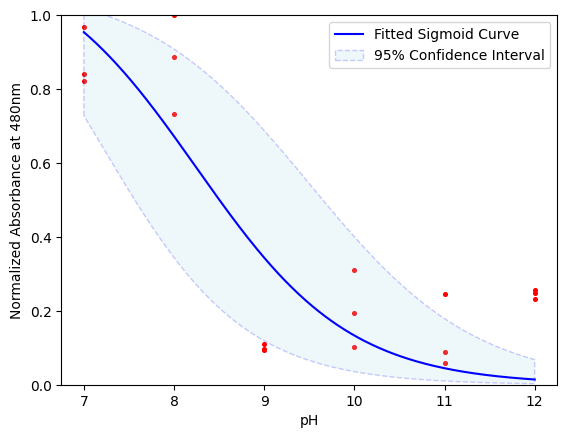

In [136]:
# Plot the filtered data and the fitted sigmoid curve with higher resolution
plt.scatter(df_filt['pH'], df_filt['normalized_absorption'], s=7, color='red')
plt.plot(fine_pH_values, fine_sigmoid_fit, label='Fitted Sigmoid Curve', color='blue')

# Add a shaded area for the 95% confidence interval
plt.fill_between(fine_pH_values, sigmoid(fine_pH_values, *confidence_interval[0]), sigmoid(fine_pH_values, *confidence_interval[1]), color='lightblue', linestyle='dashed', linewidth=1, edgecolor='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('pH')
plt.ylabel('Normalized Absorbance at 480nm')

# Set y-axis limits to be no greater than 1
plt.ylim(0, 1)

plt.legend()
plt.show()